# GNN training for SIS dynamics on a BA network with 1000 samples

## Including relevant packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dynalearn as dl
import tqdm
from scipy.spatial.distance import jensenshannon
import tensorflow as tf
import tensorflow.keras as ks
import tensorflow.keras.backend as K
import os
import getpass
from matplotlib.lines import Line2D

## Parameters and hyperparameters

In [2]:
path_to_dir = "/home/" + getpass.getuser() + "/Documents/ulaval/doctorat/projects/dynalearn/data/training/"
path_to_models = "/home/" + getpass.getuser() + "/Documents/ulaval/doctorat/projects/dynalearn/data/models/"
if os.path.exists("media/" + getpass.getuser() + "LaCie/"):
    path_to_dir = "media/" + getpass.getuser() + "LaCie/dynalearn-data/training/"
    path_to_models = "media/" + getpass.getuser() + "LaCie/dynalearn-data/models/"

    
    

param_dict = {
    "name": "sis-ba-1000",
    "graph": {"name": "BAGraph", "params": {"N": 1000, "M": 2}},
    "dynamics": {
        "name": "SIS",
        "params": {"infection": 0.04, "recovery": 0.08, "init": "None"},
    },
    "model": {
        "name": "LocalStatePredictor",
        "params": {
            "in_features": [32],
            "attn_features": [32],
            "out_features": [32],
            "n_heads": [1],
            "in_activation": "relu",
            "attn_activation": "relu",
            "out_activation": "relu",
            "weight_decay": 0.0001,
            "tf_seed": 2,
        },
    },
    "generator": {
        "name": "DynamicsGenerator",
        "params": {
            "batch_size": -1,
            "num_graphs": 1,
            "num_sample": 1000,
            "resampling_time": 2,
            "val_fraction": 0.01,
            "max_null_iter": 1,
            "with_truth": 0,
        },
        "sampler": {
            "name": "StateBiasedSampler",
            "params": {
                "sampling_bias": 0.6,
                "val_bias": 0.8,
                "replace": 1,
                "resample": 1000,
                "sample_from_weights": 0,
            },
        },
    },
    "config": {
        "optimizer": "Adam",
        "initial_lr": 0.0005,
        "loss": "categorical_crossentropy",
        "schedule": {"epoch": 10, "factor": 2},
        "epochs": 20,
        "np_seed": 1,
    },
    "metrics": [
#         "AttentionMetrics",
#         "TrueLTPMetrics",
#         "GNNLTPMetrics",
#         "MLELTPMetrics",
#         "TrueStarLTPMetrics",
#         "GNNStarLTPMetrics",
#         "StatisticsMetrics",
        "PoissonEpidemicsMFMetrics",
        "PoissonEpidemicsSSMetrics",
    ],
    "path_to_dir": path_to_dir,
    "path_to_bestmodel": path_to_models,
    "filename_data": "data.h5",
    "filename_metrics": "metrics.h5",
    "filename_model": "model.h5",
}

## Loading the experiment settings

In [3]:
experiment = dl.Experiment(param_dict)

## Generating the training and validation datasets

In [4]:
overwrite = False
if os.path.exists(os.path.join(experiment.path_to_dir, experiment.name, experiment.filename_data)) and not overwrite:
    experiment.load_data()
else:
    experiment.generate_data()
    experiment.save_data()


## Training the GNN model

In [5]:
overwrite = False
if os.path.exists(os.path.join(experiment.path_to_dir, experiment.name, experiment.filename_model)) and not overwrite:
    experiment.load_model(best=True)
else:
    experiment.train_model()
    experiment.save_model()
    experiment.load_model(best=True)

## Computing the metrics post training

In [8]:
overwrite = False
if os.path.exists(os.path.join(experiment.path_to_dir, experiment.name, experiment.filename_metrics)) and not overwrite:
    experiment.load_metrics()
else:
    experiment.compute_metrics()
    experiment.save_metrics()

## Showing LTPs

In [9]:
transitions = [(0, 1), (1, 0)]
transition_labels = [("S", "I"), ("I", "S")]
fontsize=14

color_true = [dl.utilities.color_pale["blue"], dl.utilities.color_pale["red"]]
color_gnn = [dl.utilities.color_dark["blue"], dl.utilities.color_dark["red"]]
handles = []

fig, ax = plt.subplots(1,1, figsize=(5, 4))
for i, t in enumerate(transitions):
    x, y, err = experiment.metrics["TrueLTPMetrics"].aggregate(experiment.metrics["TrueLTPMetrics"].data["ltp/train"],in_state=t[0], out_state=t[1])
    ax.fill_between(x, y - err, y + err, color=color_gnn[i], alpha=0.3)
    ax.plot(x, y, linestyle='-', color=color_true[i], label="True")
    
    x, y, err = experiment.metrics["GNNLTPMetrics"].aggregate(experiment.metrics["GNNLTPMetrics"].data["ltp/train"], in_state=t[0], out_state=t[1])
    ax.fill_between(x, y - err, y + err, color=color_gnn[i], alpha=0.3)
    ax.plot(x, y, linestyle='--', color=color_gnn[i], label="GNN")

    x, y, err = experiment.metrics["MLELTPMetrics"].aggregate(experiment.metrics["MLELTPMetrics"].data["ltp/train"], in_state=t[0], out_state=t[1])
    ax.errorbar(x, y, yerr=err, 
                linestyle='None', 
                marker='o', 
                color=color_gnn[i], 
                alpha=0.3, 
                markeredgewidth=1,
                markeredgecolor='k',
                label="MLE")
    
plt.xlabel(r"Number of infected neighbors $[\ell]$", fontsize=fontsize)
plt.ylabel(r"Local transition probability $[p^{\mu\to\nu}_\ell]$", fontsize=fontsize)
plt.show()

KeyError: 'TrueLTPMetrics'

## LTP on the star graph

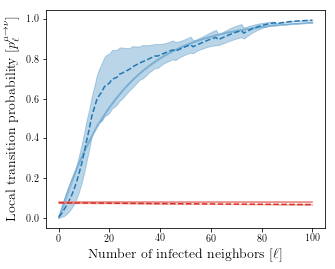

In [8]:
transitions = [(0, 1), (1, 0)]
transition_labels = [("S", "I"), ("I", "S")]
fontsize=14

color_true = [dl.utilities.color_pale["blue"], dl.utilities.color_pale["red"]]
color_gnn = [dl.utilities.color_dark["blue"], dl.utilities.color_dark["red"]]
handles = []

fig, ax = plt.subplots(1,1, figsize=(5, 4))
for i, t in enumerate(transitions):
    x, y, err = experiment.metrics["TrueStarLTPMetrics"].aggregate(experiment.metrics["TrueStarLTPMetrics"].data["ltp"],in_state=t[0], out_state=t[1])
    ax.fill_between(x, y - err, y + err, color=color_gnn[i], alpha=0.3)
    ax.plot(x, y, linestyle='-', color=color_true[i], label="True")
    
    x, y, err = experiment.metrics["GNNStarLTPMetrics"].aggregate(experiment.metrics["GNNStarLTPMetrics"].data["ltp"], in_state=t[0], out_state=t[1])
    ax.fill_between(x, y - err, y + err, color=color_gnn[i], alpha=0.3)
    ax.plot(x, y, linestyle='--', color=color_gnn[i], label="GNN")

    
plt.xlabel(r"Number of infected neighbors $[\ell]$", fontsize=fontsize)
plt.ylabel(r"Local transition probability $[p^{\mu\to\nu}_\ell]$", fontsize=fontsize)
plt.show()

## Showing Loss descent

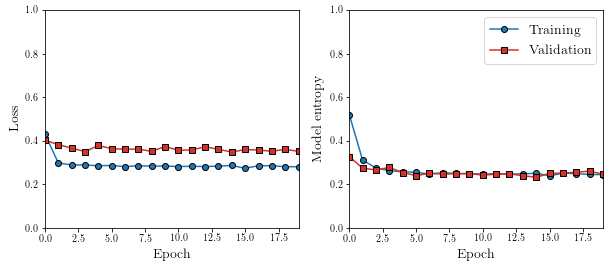

In [9]:

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

e = np.arange(experiment.epochs)

ax[0].plot(e, experiment.history['loss'], 
        color=dl.utilities.color_dark["blue"], 
        marker="o", 
        markeredgewidth=1, 
        markeredgecolor="k",
        linestyle="-")

ax[0].plot(e, experiment.history['val_loss'], 
        color=dl.utilities.color_dark["red"], 
        marker="s", 
        markeredgewidth=1, 
        markeredgecolor="k",
        linestyle="-")



ax[1].plot(e, experiment.history["model_entropy"], 
        color=dl.utilities.color_dark["blue"], 
        marker="o", 
        markeredgewidth=1, 
        markeredgecolor="k",
        linestyle="-",
        label="Training")

ax[1].plot(e, experiment.history["val_model_entropy"], 
        color=dl.utilities.color_dark["red"], 
        marker="s", 
        markeredgewidth=1, 
        markeredgecolor="k",
        linestyle="-",
        label="Validation")

ax[0].set_xlabel(r'Epoch', fontsize=fontsize)
ax[0].set_ylabel(r'Loss', fontsize=fontsize)
ax[0].set_xlim([0, 19])
ax[0].set_ylim([0, 1])

ax[1].set_xlabel(r'Epoch', fontsize=fontsize)
ax[1].set_ylabel(r'Model entropy', fontsize=fontsize)
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 1])
ax[1].legend(fontsize=fontsize)

plt.show()


## Showing phase transition

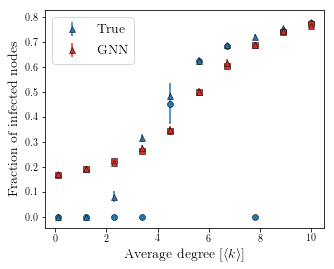

In [12]:
avgk = experiment.metrics["PoissonEpidemicsSSMetrics"].data["parameters"]
low_avg_s = experiment.metrics["PoissonEpidemicsSSMetrics"].data["true_low_avg"]
low_std_s = experiment.metrics["PoissonEpidemicsSSMetrics"].data["true_low_std"]
high_avg_s = experiment.metrics["PoissonEpidemicsSSMetrics"].data["true_high_avg"]
high_std_s = experiment.metrics["PoissonEpidemicsSSMetrics"].data["true_high_std"]


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.errorbar(avgk, 1 - low_avg_s[:,0], yerr=low_std_s[:,0], 
            color=dl.utilities.color_dark["blue"], 
            marker='o', 
            markeredgewidth=0.5,
            markeredgecolor="k",
            linestyle='None')
ax.errorbar(avgk, 1 - high_avg_s[:,0], yerr=high_std_s[:,0], 
            color=dl.utilities.color_dark["blue"], 
            marker='^', 
            markeredgewidth=0.5,
            markeredgecolor="k",
            linestyle='None', 
            label=r"True")

low_avg_s = experiment.metrics["PoissonEpidemicsSSMetrics"].data["gnn_low_avg"]
low_std_s = experiment.metrics["PoissonEpidemicsSSMetrics"].data["gnn_low_std"]
high_avg_s = experiment.metrics["PoissonEpidemicsSSMetrics"].data["gnn_high_avg"]
high_std_s = experiment.metrics["PoissonEpidemicsSSMetrics"].data["gnn_high_std"]
ax.errorbar(avgk, 1 - low_avg_s[:,0], yerr=low_std_s[:,0], 
            color=dl.utilities.color_dark["red"], 
            marker='s', 
            markeredgewidth=0.5,
            markeredgecolor="k",
            linestyle='None')
ax.errorbar(avgk, 1 - high_avg_s[:,0], yerr=high_std_s[:,0], 
            color=dl.utilities.color_dark["red"], 
            marker='^', 
            markeredgewidth=0.5,
            markeredgecolor="k",
            linestyle='None', 
            label=r"GNN")

ax.set_xlabel(r"Average degree $[\langle k \rangle]$", fontsize=fontsize)
ax.set_ylabel(r"Fraction of infected nodes", fontsize=fontsize)
ax.legend(fontsize=fontsize)

plt.show()


In [11]:
experiment.metrics["PoissonEpidemicsMFMetrics"].data


{'gnn_high_fp': array([[0.82933169, 0.17066831],
        [0.82833565, 0.17166435],
        [0.8272217 , 0.1727783 ],
        [0.82607711, 0.17392289],
        [0.82490131, 0.17509869],
        [0.82369371, 0.17630629],
        [0.82245371, 0.17754629],
        [0.82118071, 0.17881929],
        [0.81987414, 0.18012586],
        [0.81853339, 0.18146661],
        [0.81726842, 0.18273158],
        [0.81586135, 0.18413865],
        [0.81441857, 0.18558143],
        [0.81293961, 0.18706039],
        [0.81142401, 0.18857599],
        [0.80987141, 0.19012859],
        [0.80828147, 0.19171853],
        [0.80665394, 0.19334606],
        [0.80511875, 0.19488125],
        [0.80341972, 0.19658028],
        [0.8016829 , 0.1983171 ],
        [0.79990837, 0.20009163],
        [0.7980963 , 0.2019037 ],
        [0.79624698, 0.20375302],
        [0.79436079, 0.20563921],
        [0.79243821, 0.20756179],
        [0.79047984, 0.20952016],
        [0.78864194, 0.21135806],
        [0.78661846, 0.21338154],